### Import Libraries

In [1]:
# !pip install tensorflow==2.9
# !pip install protobuf==3.20.0
# !set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
# !pip install nsfw_detector
# !pip install pillow
# !pip install opencv-python
# !pip install nudenet
# !pip install torch torchvision torchaudio

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pickle
import numpy as np
from tqdm import notebook

In [3]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models

In [5]:
from nsfw_detector import predict
from nudenet import NudeDetector

In [9]:
!python -V

Python 3.8.18


In [7]:
!pip show nsfw_detector

Name: nsfw-detector
Version: 1.1.1
Summary: NSFW Image Detection with Deep Learning
Home-page: https://github.com/GantMan/nsfw_model
Author: Prakhar Baveja
Author-email: prakhar.baveja@gmail.com
License: GPLv3
Location: c:\users\partha\.conda\envs\mmcm\lib\site-packages
Requires: pillow, tensorflow, tensorflow-hub
Required-by: 


### NSFW

In [7]:
model = predict.load_model(r'D:\Code\Data\Content Moderation Data\models\nsfw_mobilenet2.224x224.h5')

In [8]:
img_path = "D:/Code/Data/Content Moderation Data/img_moderation_samples/nude.png"

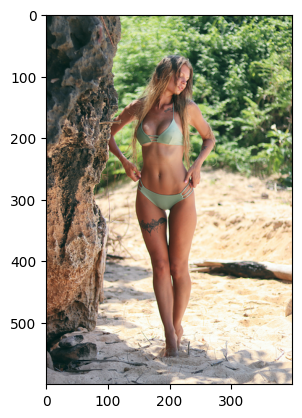

In [9]:
img = cv2.imread(img_path)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()

In [10]:
predict.classify(model, img_path)

D:/Code/Data/Content Moderation Data/img_moderation_samples/nude.png size: (224, 224)
1/1 [==============================] - 1s 729ms/step


{'D:/Code/Data/Content Moderation Data/img_moderation_samples/nude.png': {'drawings': 0.0020929654128849506,
  'hentai': 0.00040534225990995765,
  'neutral': 0.00898473709821701,
  'porn': 0.005278097931295633,
  'sexy': 0.983238935470581}}

In [11]:
detector = NudeDetector() 

In [12]:
detector.detect(img_path)

[{'class': 'BELLY_EXPOSED',
  'score': 0.7689375877380371,
  'box': [163, 219, 58, 67]},
 {'class': 'FEMALE_BREAST_COVERED',
  'score': 0.7682443857192993,
  'box': [179, 165, 48, 46]},
 {'class': 'FEMALE_BREAST_COVERED',
  'score': 0.7463535070419312,
  'box': [142, 165, 41, 48]},
 {'class': 'FEMALE_GENITALIA_COVERED',
  'score': 0.6772170066833496,
  'box': [181, 297, 32, 29]},
 {'class': 'FEET_EXPOSED',
  'score': 0.5859442949295044,
  'box': [188, 500, 37, 58]},
 {'class': 'FACE_FEMALE',
  'score': 0.5140568017959595,
  'box': [200, 90, 33, 39]},
 {'class': 'ARMPITS_EXPOSED',
  'score': 0.3605690896511078,
  'box': [224, 162, 23, 28]}]

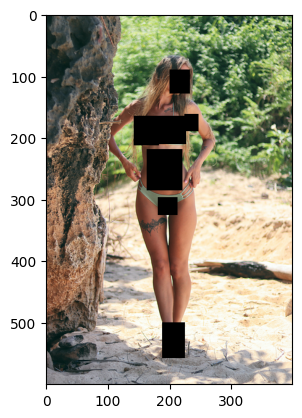

In [13]:
new_path = r"D:\Code\Data\Content Moderation Data\outputs\censored.png"
detector.censor(img_path, output_path=new_path)
Out_Image = cv2.cvtColor(cv2.imread(new_path), cv2.COLOR_BGR2RGB)
plt.imshow(Out_Image)

### Violence Detection and Classification

In [6]:
data_dir = r"D:\Code\Data\Content Moderation Data\violence_dataset"
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'val/')
batch_size = 10
num_workers = 2

In [7]:
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization])}

In [8]:
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)

In [9]:
loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader
}

loaders_transfer = loaders_scratch.copy()
use_cuda = torch.cuda.is_available()

In [10]:
# Specify model architecture 
model_transfer = models.resnet50(pretrained=False)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 2, bias=True)

fc_parameters = model_transfer.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()

pickle.dump(model_transfer,open(r"D:\Code\Data\Content Moderation Data\models\violence_resnetmain.pkl","wb"))

In [11]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001)

In [12]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in notebook.tqdm(range(1, n_epochs+1)):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in notebook.tqdm(enumerate(loaders['train']), leave=False):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            optimizer.zero_grad()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            state = {'epoch': epoch + 1, 'state_dict': model.state_dict(), 

                     'optimizer': optimizer.state_dict(), 'loss': loss, }
            torch.save(state, save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [21]:
save_path = r'D:\Code\Data\Content Moderation Data\models\main_model.pt'
train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, save_path)

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1, Batch 1 loss: 0.765180
Epoch: 1 	Training Loss: 0.709299 	Validation Loss: 0.651328
Validation loss decreased (inf --> 0.651328).  Saving model ...


0it [00:00, ?it/s]

Epoch 2, Batch 1 loss: 0.641523
Epoch: 2 	Training Loss: 0.726438 	Validation Loss: 0.667111


0it [00:00, ?it/s]

Epoch 3, Batch 1 loss: 0.702885
Epoch: 3 	Training Loss: 0.715277 	Validation Loss: 0.660306


0it [00:00, ?it/s]

Epoch 4, Batch 1 loss: 0.697704
Epoch: 4 	Training Loss: 0.713956 	Validation Loss: 0.670689


0it [00:00, ?it/s]

Epoch 5, Batch 1 loss: 0.674467
Epoch: 5 	Training Loss: 0.732524 	Validation Loss: 0.656591


0it [00:00, ?it/s]

Epoch 6, Batch 1 loss: 0.726525
Epoch: 6 	Training Loss: 0.713074 	Validation Loss: 0.963989


0it [00:00, ?it/s]

Epoch 7, Batch 1 loss: 1.020773
Epoch: 7 	Training Loss: 0.705699 	Validation Loss: 0.667007


0it [00:00, ?it/s]

Epoch 8, Batch 1 loss: 0.689749
Epoch: 8 	Training Loss: 0.715286 	Validation Loss: 0.709921


0it [00:00, ?it/s]

Epoch 9, Batch 1 loss: 0.708982
Epoch: 9 	Training Loss: 0.718037 	Validation Loss: 0.662673


0it [00:00, ?it/s]

Epoch 10, Batch 1 loss: 0.668636
Epoch: 10 	Training Loss: 0.706268 	Validation Loss: 0.717445


0it [00:00, ?it/s]

Epoch 11, Batch 1 loss: 0.745578
Epoch: 11 	Training Loss: 0.683288 	Validation Loss: 0.906623


0it [00:00, ?it/s]

Epoch 12, Batch 1 loss: 0.859732
Epoch: 12 	Training Loss: 0.715672 	Validation Loss: 0.681402


0it [00:00, ?it/s]

Epoch 13, Batch 1 loss: 0.718839
Epoch: 13 	Training Loss: 0.714520 	Validation Loss: 0.723902


0it [00:00, ?it/s]

Epoch 14, Batch 1 loss: 0.660731
Epoch: 14 	Training Loss: 0.682061 	Validation Loss: 0.954296


0it [00:00, ?it/s]

Epoch 15, Batch 1 loss: 0.897136
Epoch: 15 	Training Loss: 0.704112 	Validation Loss: 0.845056


0it [00:00, ?it/s]

Epoch 16, Batch 1 loss: 0.605584
Epoch: 16 	Training Loss: 0.680569 	Validation Loss: 0.785954


0it [00:00, ?it/s]

Epoch 17, Batch 1 loss: 0.689405
Epoch: 17 	Training Loss: 0.694393 	Validation Loss: 0.750254


0it [00:00, ?it/s]

Epoch 18, Batch 1 loss: 0.723870
Epoch: 18 	Training Loss: 0.704673 	Validation Loss: 0.894099


0it [00:00, ?it/s]

Epoch 19, Batch 1 loss: 0.677972
Epoch: 19 	Training Loss: 0.720464 	Validation Loss: 0.774630


0it [00:00, ?it/s]

Epoch 20, Batch 1 loss: 0.629686
Epoch: 20 	Training Loss: 0.691225 	Validation Loss: 0.657902


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
model = pickle.load(open(r"D:\Code\Data\Content Moderation Data\models\violence_resnetmain.pkl","rb"))
checkpoint = torch.load(r"D:\Code\Data\Content Moderation Data\models\main_model.pt")

In [13]:
model = pickle.load(open(r"D:\Code\Data\Content Moderation Data\models\vd_resnetmain.pkl","rb"))
checkpoint = torch.load(r"D:\Code\Data\Content Moderation Data\models\vd_main_model.pt")

In [14]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [15]:
class_names = loaders_transfer['train'].dataset.classes
class_names

['safe', 'unsafe']

In [16]:
def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

def predict_image(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

def run_app(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    prediction = predict_image(model, class_names, img_path)
    return prediction

In [17]:
image = "D:/Code/Data/Content Moderation Data/violence_dataset/train/safe/49152357-group-of-casual-people-social-gathering-concept.jpg"

In [18]:
predict_image(model, class_names, image)

'safe'

In [19]:
# img = Image.open(image)
# img

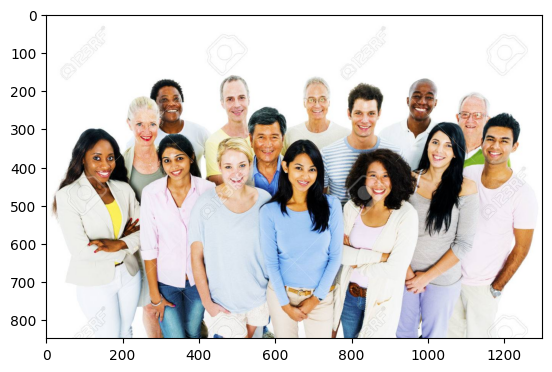

In [20]:
img = cv2.imread(image)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()

In [43]:
img = load_input_image(image)

model = model.cpu()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [44]:
img, _ = next(iter(train_loader))
pred = model(img)
pred[1,1]

tensor(0.7800, grad_fn=<SelectBackward0>)

In [45]:
pred

tensor([[ 0.0350,  0.8422],
        [ 0.1706,  0.7800],
        [ 0.1855,  0.6651],
        [ 0.1970,  0.6678],
        [-0.0760,  0.9573],
        [ 0.4915,  0.5617],
        [ 0.0850,  0.9700],
        [ 0.1610,  0.7509],
        [ 0.1008,  0.6571],
        [ 0.2043,  0.9430]], grad_fn=<AddmmBackward0>)

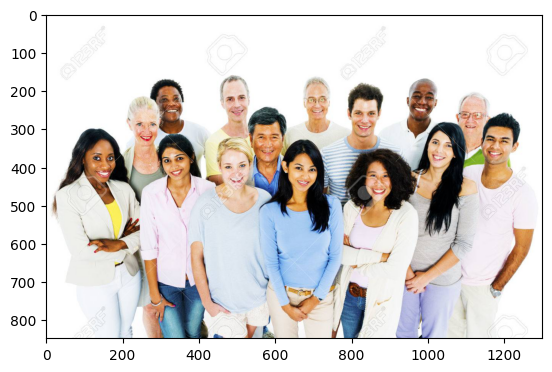

'safe'

In [21]:
run_app(image)

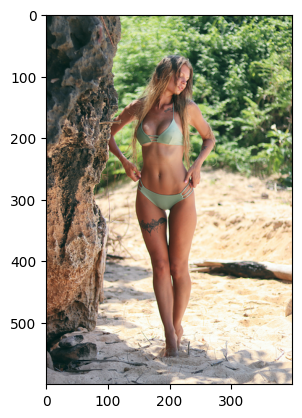

'unsafe'

In [22]:
run_app("D:/Code/Data/Content Moderation Data/img_moderation_samples/nude.png")

In [31]:
path = "D:/Code/Data/Content Moderation Data/img_moderation_samples/"
imgs = os.listdir(path)
images = [f'{path}{imgname}' for imgname in imgs]

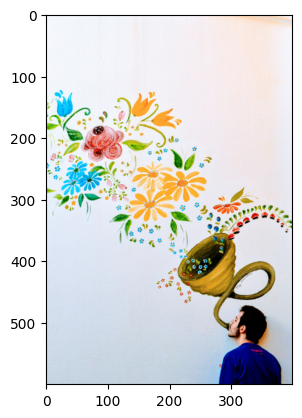

safe 




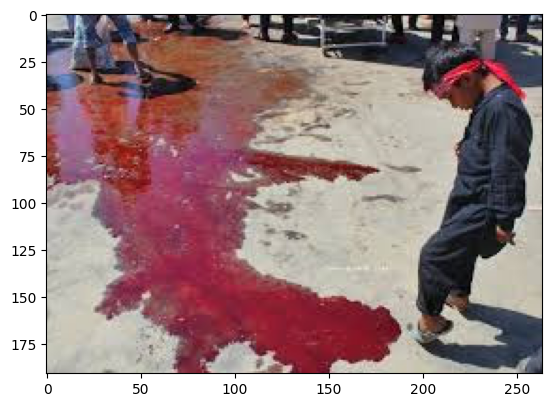

unsafe 




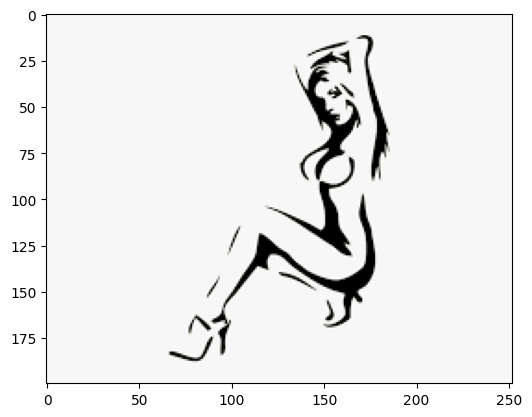

safe 




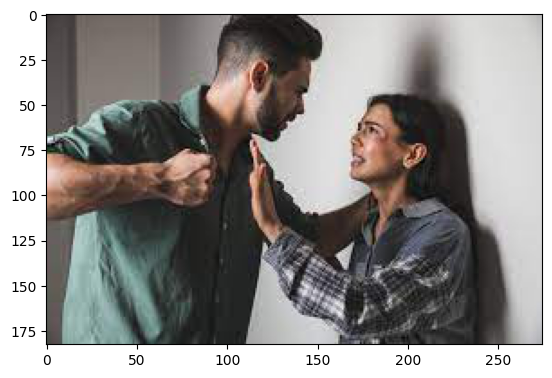

unsafe 




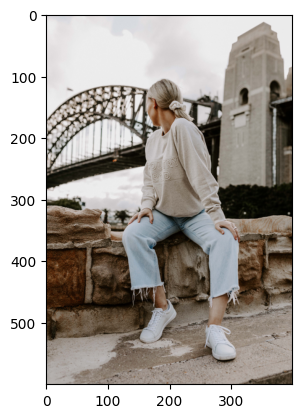

unsafe 




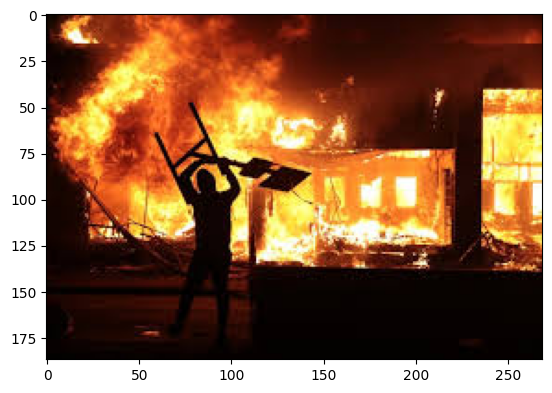

unsafe 




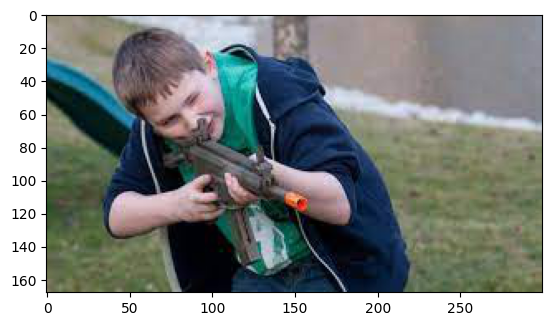

unsafe 




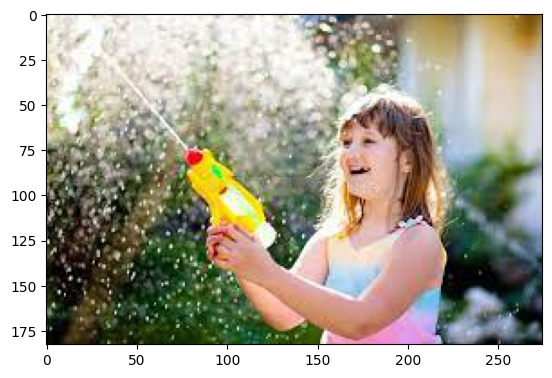

unsafe 




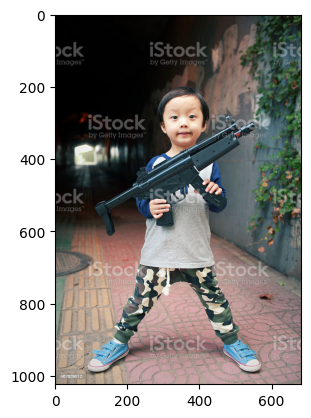

unsafe 




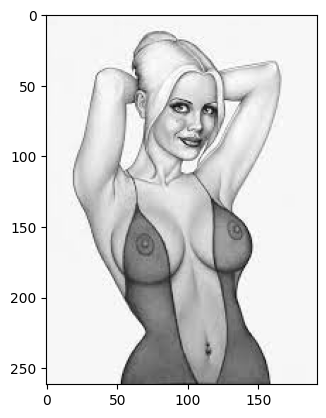

unsafe 




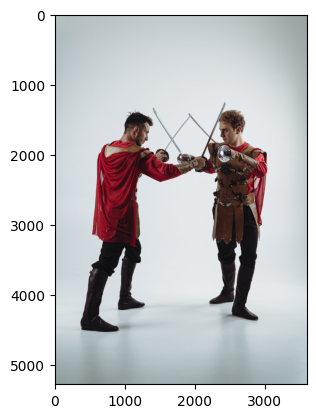

safe 




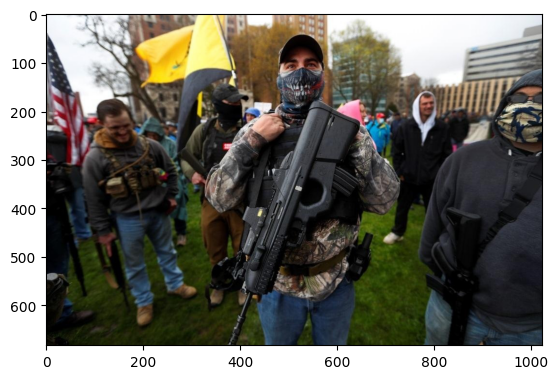

unsafe 




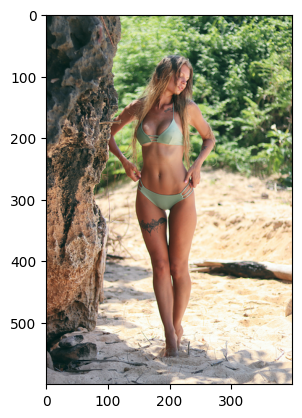

unsafe 




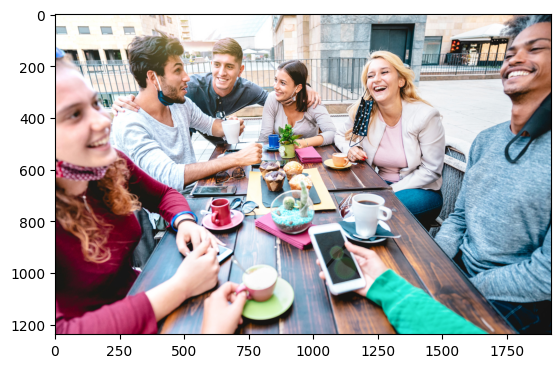

safe 




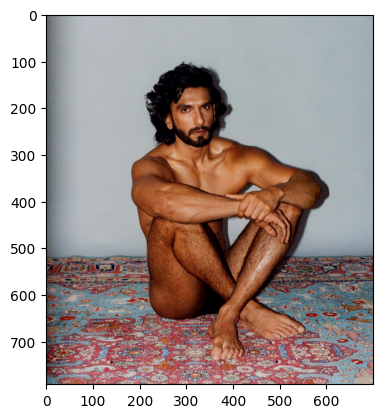

unsafe 




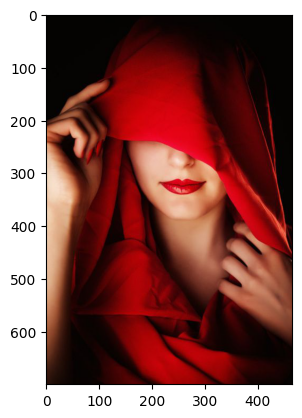

unsafe 




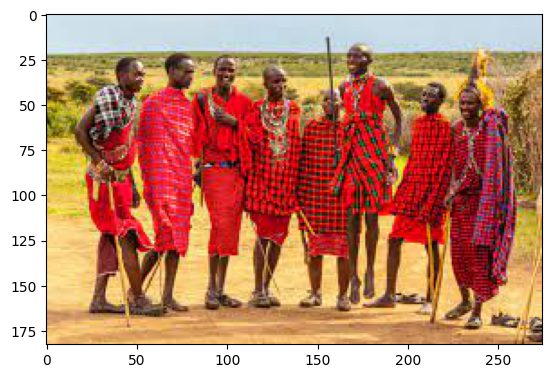

safe 




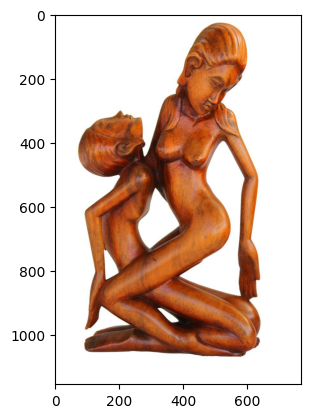

safe 




In [32]:
for image in images:
    print(run_app(image), "\n\n")